In [ ]:
# lib
import talib
import pandas as pd
import yfinance as yf
import datetime as dt
import json
import csv
import requests

In [ ]:
from yfDataLoader import *
yfd = YfinanceDataLoader()

In [ ]:
yfd.download_data()

In [ ]:
yfd.dump_data()

In [ ]:
# fix bug
import os

folder_path = 'E:\\amequant_data'
common_prefix = 'amequant_data'

for filename in os.listdir(folder_path):
    if filename.startswith(common_prefix):
        new_filename = filename.split(common_prefix, 1)[1]
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))


In [ ]:
# 获取数据下载时间
# read time log
with open('dmypy.json', 'r') as f:
    jsdata = json.load(f)

now = dt.datetime.now()
next_date = dt.datetime.strptime(jsdata['end_date'], '%Y-%m-%d') + dt.timedelta(days=1)

if now >= next_date:
    start_date = next_date
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = now.strftime('%Y-%m-%d')
    jsdata['end_date'] = end_date

# update time log
with open('dmypy.json', 'w') as f:
    json.dump(jsdata, f, indent=4)


In [ ]:
# 获取股票数据
# path 1 从datahub.io中搜索数据（数据不全）
# all_tickers = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')
# all_tickers_symbols = all_tickers.Symbol.tolist()
# path 2 从www.alphavantage.co中拉取股票代码
# 设置API密钥和API地址
with open('dmypy.json', 'r') as f:
    jsdata = json.load(f)

api_key = jsdata['alpha_vantage_key']
api_url = f'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey={api_key}'

# 发送请求并获取JSON数据
with requests.Session() as req:
    response = req.get(api_url)
    data = response.content.decode('utf-8')
    cr = csv.reader(data.splitlines(), delimiter=',')
    cr_list = list(cr)

df = pd.DataFrame(cr_list[1:], columns=cr_list[0])
    
# 提取股票代码并打印
tickers = list(df['symbol'])
print(len(tickers))


In [ ]:
start_date = '2022-01-01'
end_date = '2022-01-15'
proxy = '127.0.0.1:21882'

tickers = ['BIDU']
yfd.set_tickers_list(tickers)
data = yfd.download_data(start_date, end_date)


In [ ]:
bidu = yf.download('BIDU', start=start_date, end=end_date, threads=True, proxy=proxy)

In [ ]:
bidu

In [ ]:
# bidu1 = bidu.reset_index()
bidu1 = bidu.reset_index()
# bidu1.index
bidu1.set_index('Date')
bidu1.index

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
mpf.plot(bidu1.set_index('Date'), type='candle', volume=True, mav=(5, 10, 20), figsize=(16, 9), style='yahoo')

In [ ]:
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 9))
# bidu1.set_index('Date')
bidu.index = [mdates.date2num(d) for d in bidu.index]
candlestick_ohlc(ax, bidu[['Date', 'Open', 'Low', 'High', 'Close']].values, width=0.0005, colorup='red', colordown='green', alpha=0.75)

# 设置x轴
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
plt.show()

In [ ]:
symbol = ['AAPL']
start_date = '2020-01-01'
end_date = '2022-03-22'
df = yf.download(symbol, start='2022-01-01',end='2022-03-01', threads=True, proxy='127.0.0.1:21882')
df
# df = yf.download(symbol, start=start_date, end=end_date, threads=True)

In [ ]:
# show data
df.size

In [ ]:
# 计算BOLL线
df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
df['STD20'] = talib.STDDEV(df['Close'], timeperiod=20)
df['UpperBand'] = df['MA20'] + 2 * df['STD20']
df['LowerBand'] = df['MA20'] - 2 * df['STD20']

# 计算买卖信号
df['Signal'] = 0
df.loc[df['Close'] < df['LowerBand'], 'Signal'] = 1
df.loc[df['Close'] > df['UpperBand'], 'Signal'] = -1

# 计算持仓状态和收益
df['Position'] = df['Signal'].shift(1)
df['Position'].fillna(method='ffill', inplace=True)
df['Returns'] = df['Close'] * df['Position'].shift(1)

# 计算累计收益率和绘图
df['CumReturns'] = (df['Returns'].cumsum() + 1).fillna(1)
df[['Close', 'MA20', 'UpperBand', 'LowerBand']].plot(figsize=(10, 6))
# df['CumReturns'].plot(figsize=(10, 6), secondary_y=True)


[*********************100%***********************]  1 of 1 completed


C:\Users\xgyxm\AppData\Local\Temp\ipykernel_6504\432505940.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data['Date'].map(mdates.date2num)


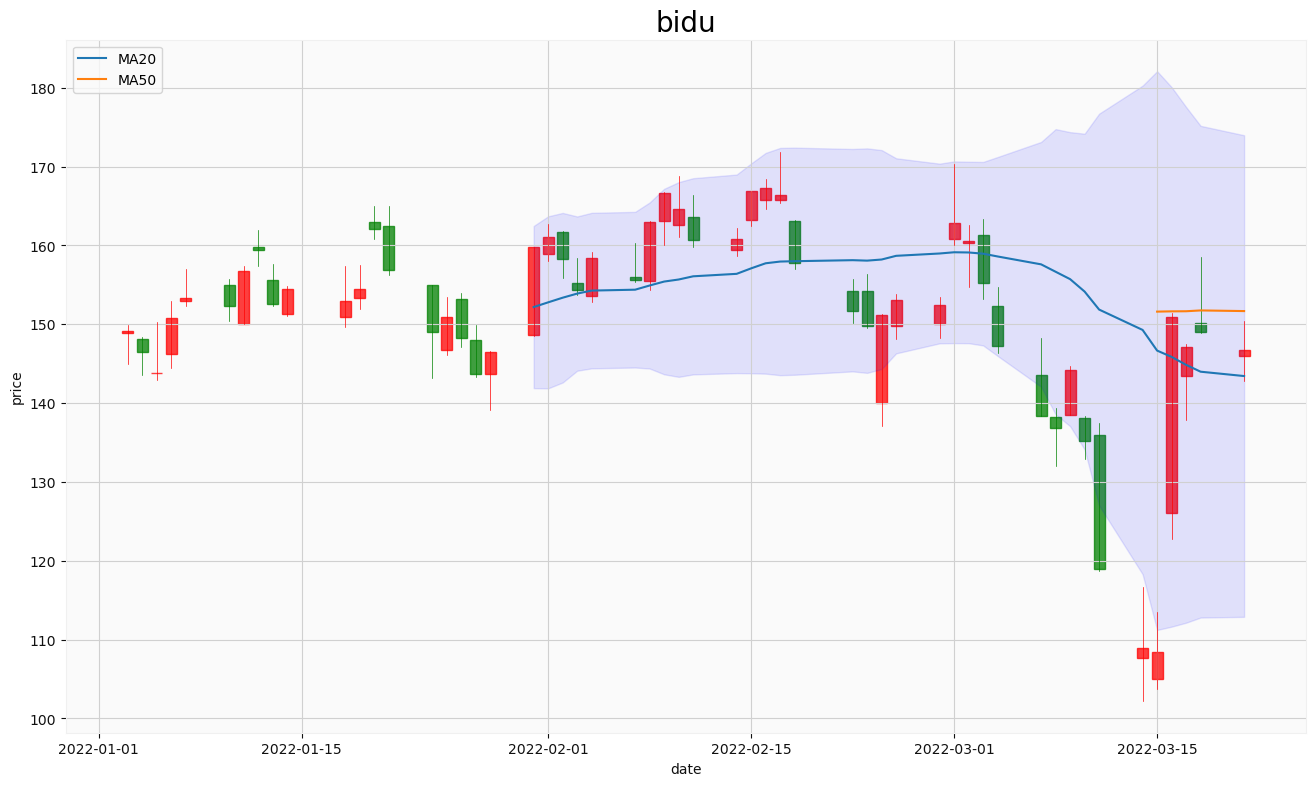

In [60]:
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# 从yfinance下载数据
yft = yf.download("BIDU", start="2022-01-01", end="2022-03-22", proxy='127.0.0.1:21882')

# 计算移动平均线和布林带
yft['MA20'] = yft['Close'].rolling(20).mean()
yft['MA50'] = yft['Close'].rolling(50).mean()
yft['stddev'] = yft['Close'].rolling(20).std()
yft['UpperBand'] = yft['MA20'] + (yft['stddev'] * 2)
yft['LowerBand'] = yft['MA20'] - (yft['stddev'] * 2)

# 准备数据
data = yft[['Open', 'High', 'Low', 'Close']] 
data.reset_index(inplace=True)
data['Date'] = data['Date'].map(mdates.date2num)

# 绘制K线图
fig, ax = plt.subplots(figsize=(16, 9))
candlestick_ohlc(ax, data.values, width=0.75, colorup='red', colordown='green', alpha=0.75)

# 绘制移动平均线和布林带
ax.plot(yft['MA20'], label='MA20')
ax.plot(yft['MA50'], label='MA50')
ax.fill_between(yft.index, yft['UpperBand'], yft['LowerBand'], alpha=0.1, color='blue')

# 设置图形属性
ax.set_title('bidu', fontsize=20)
ax.legend(loc='upper left')
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.xaxis_date()


In [66]:
data

,Date,Open,High,Low,Close
0,18995.0,148.910004,149.960007,144.949997,149.100006
1,18996.0,148.139999,148.429993,143.559998,146.529999
2,18997.0,143.820007,150.259995,142.949997,143.880005
3,18998.0,146.199997,153.000000,144.410004,150.750000
4,18999.0,152.979996,157.000000,152.279999,153.330002
5,19002.0,154.949997,155.779999,150.369995,152.360001
6,19003.0,150.009995,157.330002,150.009995,156.699997
7,19004.0,159.770004,161.990005,157.399994,159.360001
8,19005.0,155.619995,157.639999,152.309998,152.509995
9,19006.0,151.259995,154.899994,151.000000,154.529999
